In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
!cp /content/kaggle.json ~/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

In [ ]:
! unzip /content/muffin-vs-chihuahua-image-classification.zip

In [ ]:
!pip install keras-tuner --upgrade
import zipfile
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import keras_tuner as kt
from keras.models import Sequential
from tensorflow import keras
from matplotlib import pyplot
from keras.callbacks import TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold, cross_val_score
import cv2
import random

In [10]:
import os
os.environ['PYTHONHASHSEED'] = str(1)

In [ ]:
device_name = tf.config.experimental.list_physical_devices('GPU')
if device_name:
    print("Found GPU at:", device_name[0].name)
    tf.config.experimental.set_memory_growth(device_name[0], True)
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

In [12]:
def random_seeds_reset(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


In [13]:
random_seeds_reset()

DATADIR_TRAIN = "/content/train"
DATADIR_TEST = "/content/test"
CATEGORIES = ["chihuahua", "muffin"]
IMG_SIZE = 150

def load_training_set():
    training_set = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR_TRAIN, category)
        class_number = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_set.append([new_array, class_number])
    random.shuffle(training_set)
    X, Y = [], []
    for feats, labs in training_set:
        X.append(feats)
        Y.append(labs)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE)
    X = X / 255
    Y = np.array(Y)
    return X, Y

def load_test_set():
    test_set = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR_TEST, category)
        class_number = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_set.append([new_array, class_number])
    X_test, y_test = [], []
    for feats, labs in test_set:
        X_test.append(feats)
        y_test.append(labs)
    X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE)
    X_test = X_test / 255
    y_test = np.array(y_test)
    return X_test, y_test


X, Y = load_training_set()
X_test, y_test = load_test_set()

input_shape = (IMG_SIZE, IMG_SIZE, 1)
X_train_c = X.reshape(len(X), IMG_SIZE, IMG_SIZE, 1)
X_test_c = X_test.reshape(len(X_test), IMG_SIZE, IMG_SIZE, 1)



In [14]:
def plot_function(history,range_):
  epochs = [i for i in range(range_)]
  fig, ax = plt.subplots(1,2)

  train_acc = history.history['accuracy']
  train_loss = history.history['loss']

  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  fig.set_size_inches(16,9)

  ax[0].plot(epochs, train_acc,"go-", label = 'Training Accuracy' )
  ax[0].plot(epochs, val_acc, "ro-", label = 'Validacion Accuracy')
  ax[0].set_title('Training Accuracy & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  ax[1].plot(epochs, train_loss, "go-", label = 'Training Loss')
  ax[1].plot(epochs, val_loss, "ro-", label = 'Validation Loss')
  ax[1].set_title('Training Loss & Validation Loss')
  ax[1].legend()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')

  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

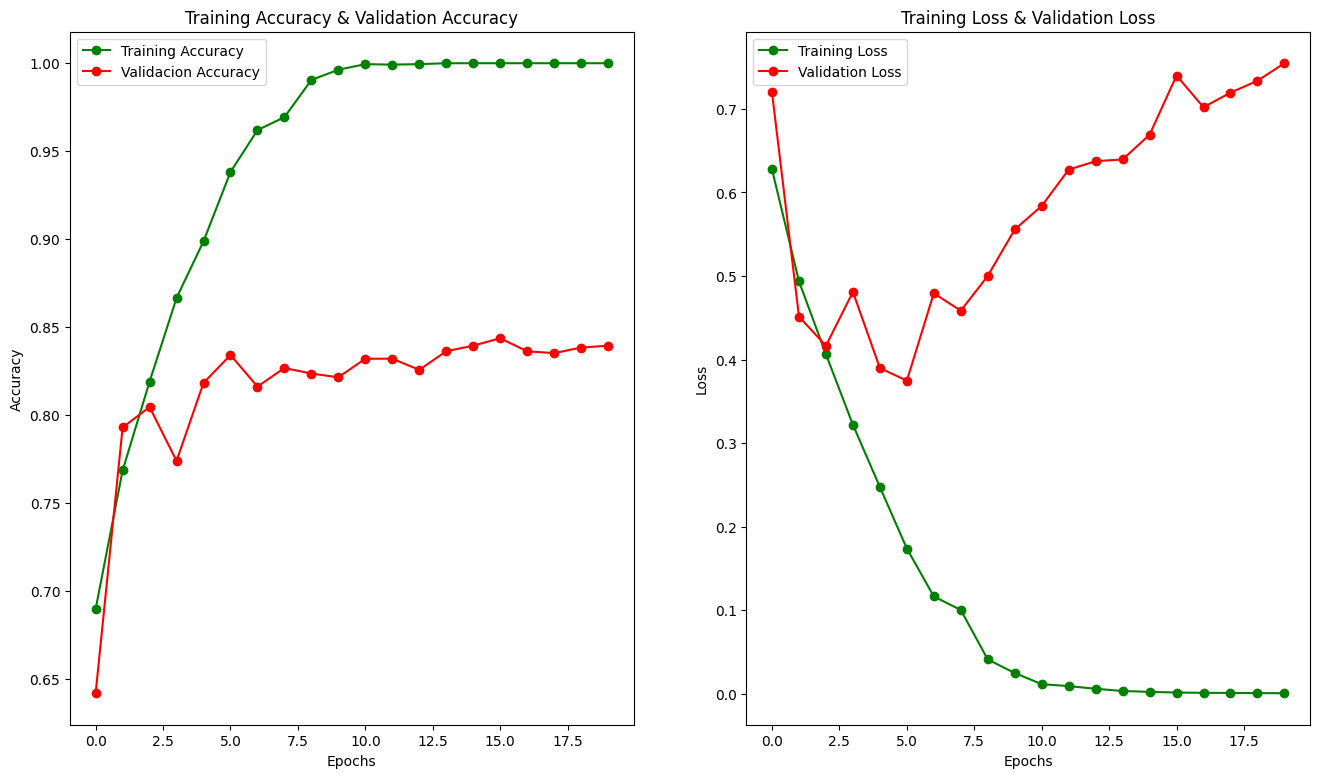

In [15]:
# FIRST CONVOLUTIONAL MODEL


conv_filters = [32, 64, 64]
kern_size = 3
pool_size = 2

NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-conv--{kern_size}-kern--{pool_size}-pool"
random_seeds_reset()

model = Sequential()
model.add(Conv2D(32,(3,3),
                 activation='relu',
                 input_shape= (IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

tensorboard = TensorBoard(log_dir=f"model_1/{NAME}")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()
history=model.fit(X_train_c, Y, batch_size=64, epochs=20, validation_split=0.2, callbacks=[tensorboard])
plot_function(history, 20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

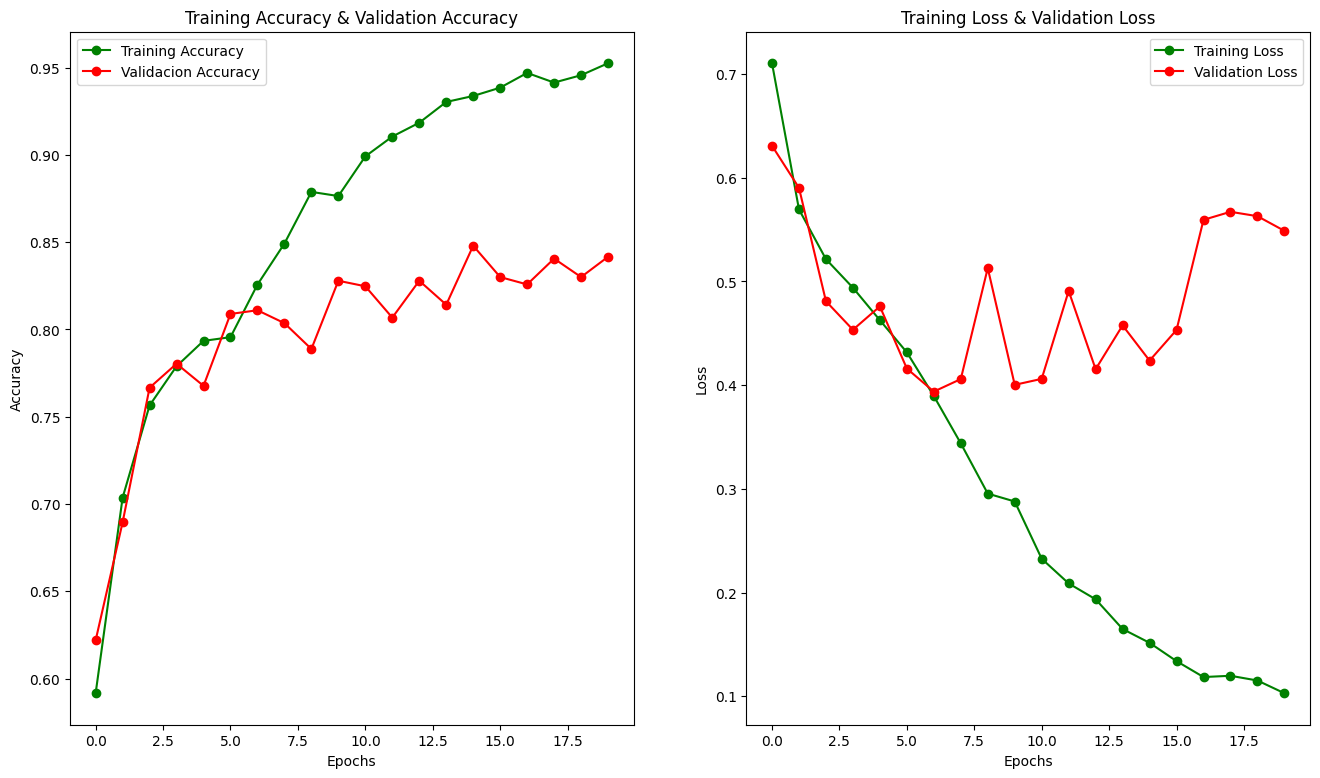

In [16]:
# Model with Dropout

conv_filters = [32, 64, 64]
kern_size = 3
pool_size = 2

NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-conv--{kern_size}-kern--{pool_size}-pool"
random_seeds_reset()

model_d = Sequential()
model_d.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model_d.add(MaxPooling2D((2,2)))
model_d.add(Conv2D(64, (3,3), activation='relu'))
model_d.add(MaxPooling2D((2,2)))

model_d.add(Flatten())
model_d.add(Dense(64, activation='relu'))
model_d.add(Dropout(0.5))
model_d.add(Dense(1, activation='sigmoid'))

tensorboard = TensorBoard(log_dir=f"model_d/{NAME}")
model_d.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model_d.summary()
history = model_d.fit(X_train_c, Y, batch_size=64, epochs=20, validation_split=0.2, callbacks=[tensorboard])
plot_function(history, 20)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

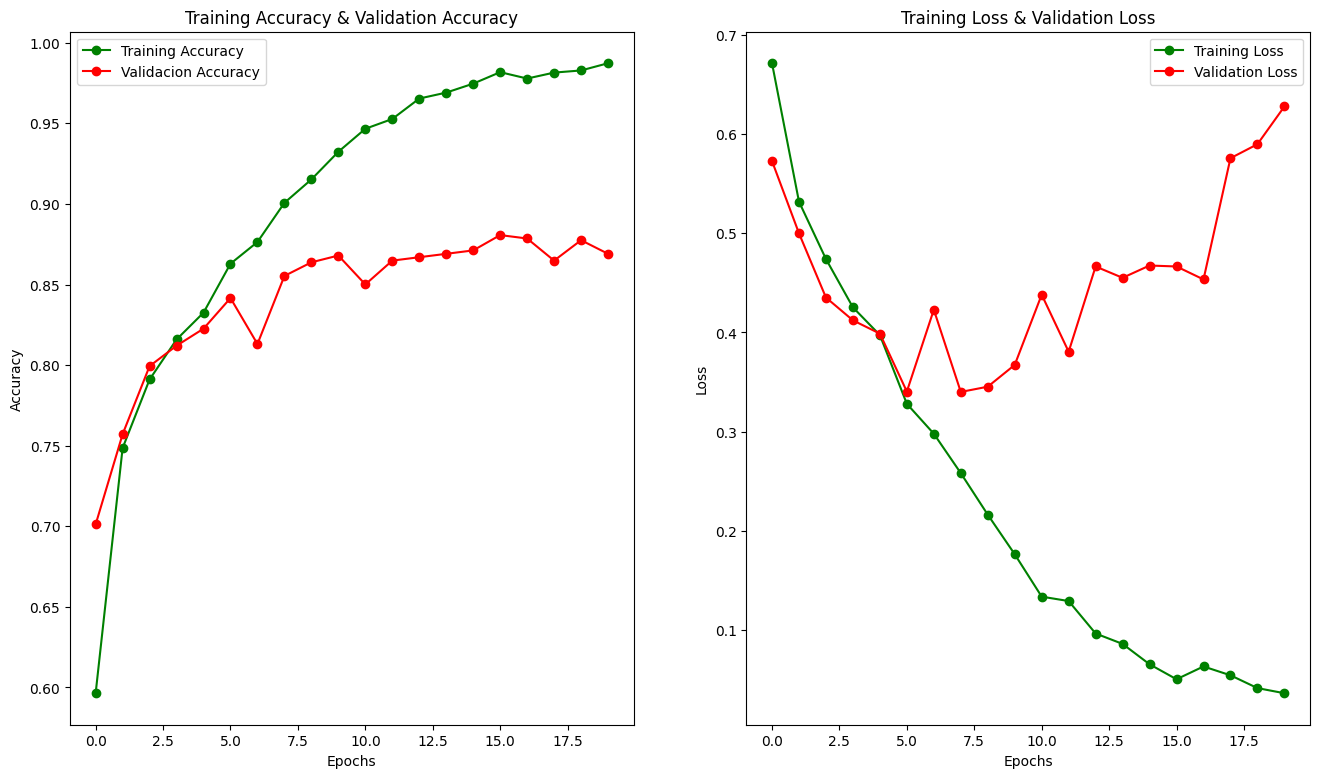

In [17]:
# Model with 3 Convolutional layers and 2 Dense layers

conv_filters = [32, 64, 128, 128, 64]
kern_size = 3
pool_size = 2

NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-{conv_filters[3]}-conv--{kern_size}-kern--{pool_size}-pool"
random_seeds_reset()

model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model_1.add(MaxPooling2D((2,2)))
model_1.add(Conv2D(64, (3,3), activation='relu'))
model_1.add(MaxPooling2D((2,2)))
model_1.add(Conv2D(128, (3,3), activation='relu'))
model_1.add(MaxPooling2D((2,2)))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

tensorboard = TensorBoard(log_dir=f"model_1/{NAME}")
model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model_1.summary()
history = model_1.fit(X_train_c, Y, batch_size=64, epochs=20, validation_split=0.2, callbacks=[tensorboard])
plot_function(history, 20)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 17, 17, 128)      

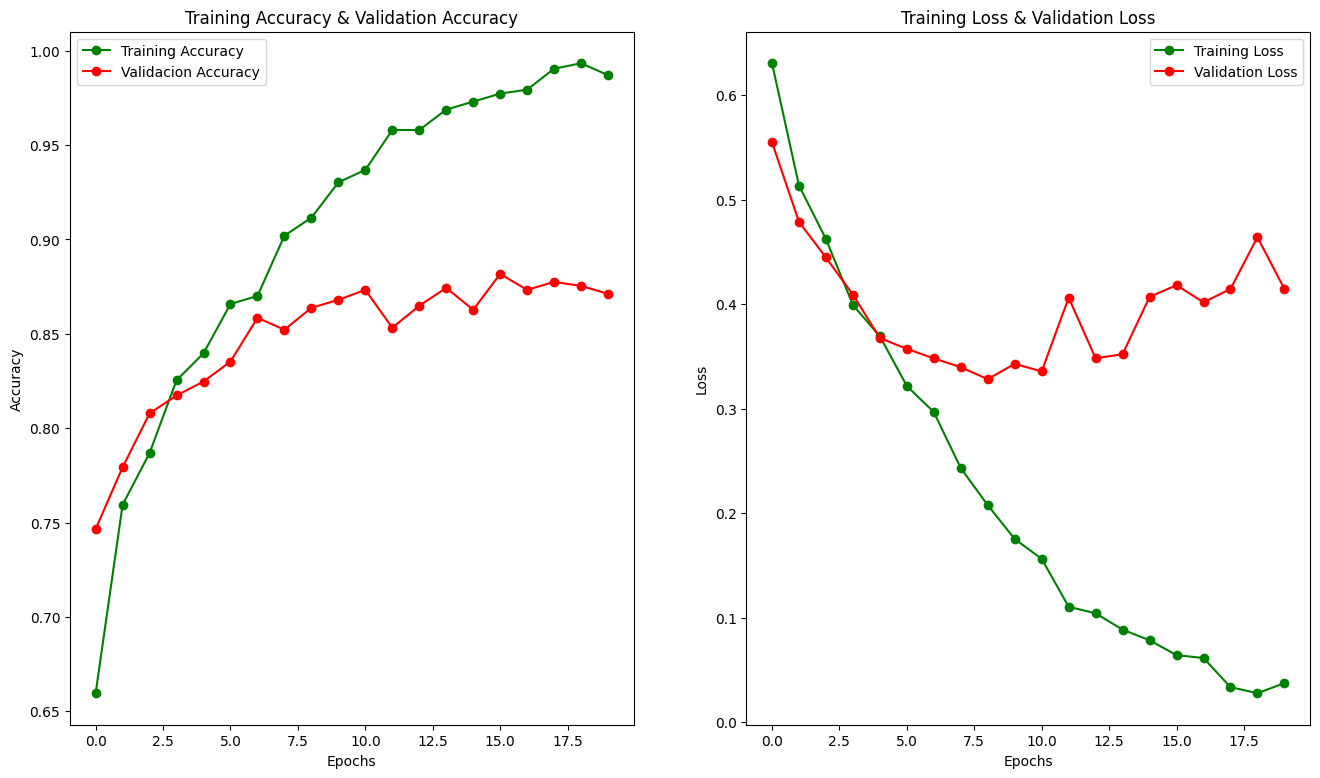

In [18]:
# Model with 3 Convolutional layers and 1 Dense layers

conv_filters = [32, 64, 128, 128]
kern_size = 3
pool_size = 2

NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-conv--{kern_size}-kern--{pool_size}-pool"
random_seeds_reset()

model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model_2.add(MaxPooling2D((2,2)))

model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))

model_2.add(Conv2D(128, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))

model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

tensorboard = TensorBoard(log_dir=f"model_2/{NAME}")
model_2.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model_2.summary()
history = model_2.fit(X_train_c, Y, batch_size=64, epochs=20, validation_split=0.2, callbacks=[tensorboard])
plot_function(history, 20)

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_332 (Conv2D)         (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_332 (MaxPool  (None, 74, 74, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_333 (Conv2D)         (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_333 (MaxPool  (None, 36, 36, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_334 (Conv2D)         (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_334 (MaxPool  (None, 17, 17, 64)      

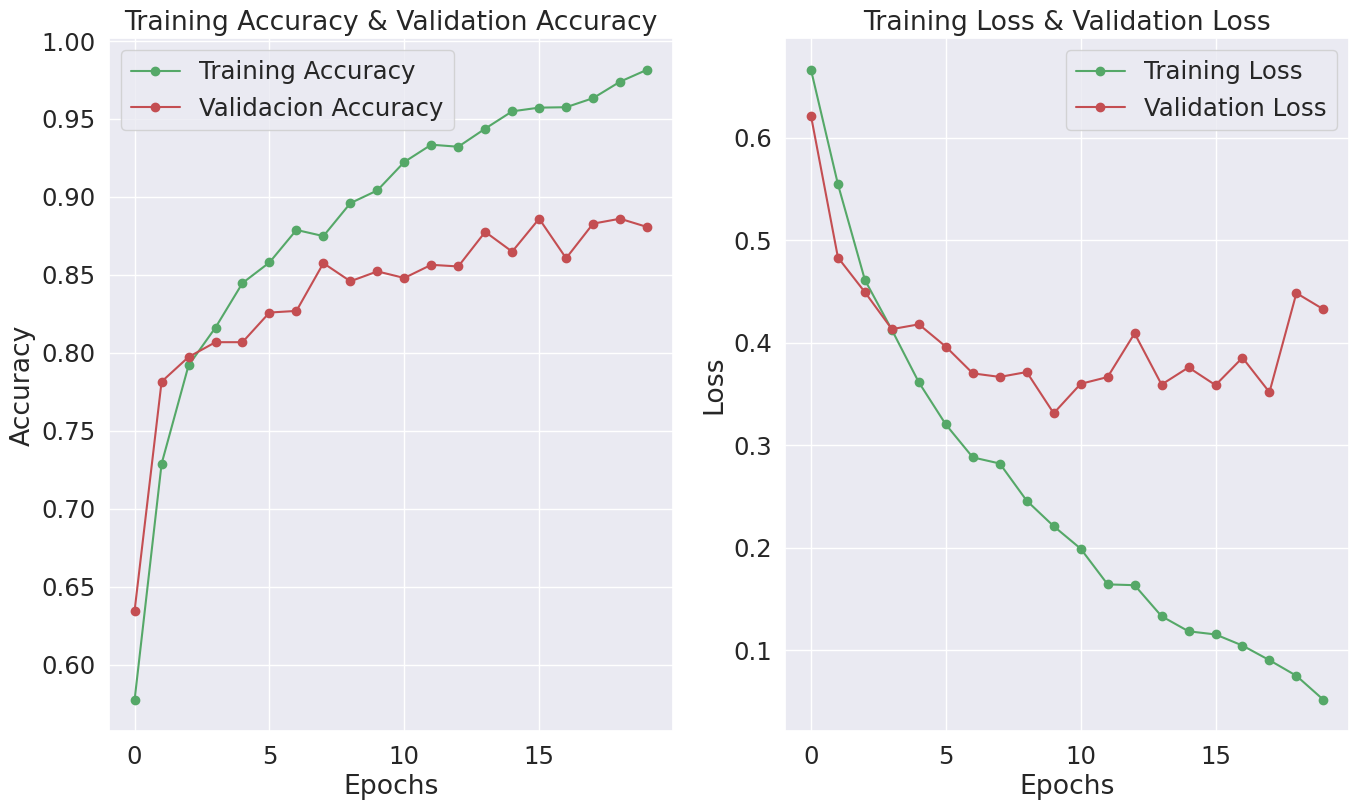

In [44]:
# Model with 4 Convolutional layers and 1 Dense layers

conv_filters = [32, 32, 64, 128, 128]
kern_size = 3
pool_size = 2

NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-{conv_filters[3]}-conv--{kern_size}-kern--{pool_size}-pool"
random_seeds_reset()

model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model_3.add(MaxPooling2D((2,2)))

model_3.add(Conv2D(32, (3,3), activation='relu'))
model_3.add(MaxPooling2D((2,2)))

model_3.add(Conv2D(64, (3,3), activation='relu'))
model_3.add(MaxPooling2D((2,2)))

model_3.add(Conv2D(128, (3,3), activation='relu'))
model_3.add(MaxPooling2D((2,2)))

model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

tensorboard = TensorBoard(log_dir=f"model_3/{NAME}")
model_3.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model_3.summary()
history = model_3.fit(X_train_c, Y, batch_size=32, epochs=20, validation_split=0.2, callbacks=[tensorboard])
plot_function(history, 20)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 17, 17, 64)       

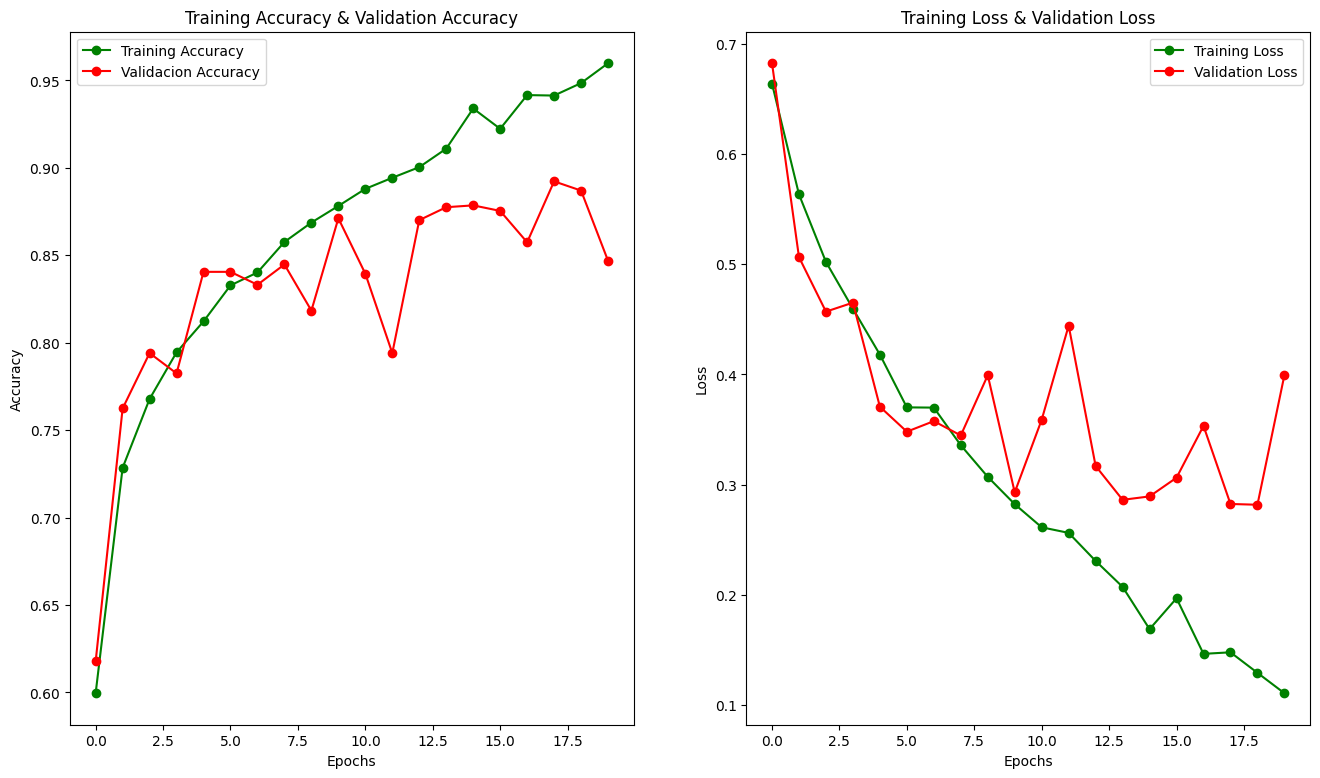

In [20]:
# Model with 4 Convolutional layers and 2 Dense layers

conv_filters = [32, 32, 64, 128, 64, 128]
kern_size = 3
pool_size = 2

NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-conv--{kern_size}-kern--{pool_size}-pool"

random_seeds_reset()

model_4 = Sequential()
model_4.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model_4.add(MaxPooling2D((2,2)))

model_4.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model_4.add(MaxPooling2D((2,2)))

model_4.add(Conv2D(64, (3,3), activation='relu'))
model_4.add(MaxPooling2D((2,2)))

model_4.add(Conv2D(128, (3,3), activation='relu'))
model_4.add(MaxPooling2D((2,2)))

model_4.add(Flatten())
model_4.add(Dropout(0.5))

model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(128, activation='relu'))

model_4.add(Dense(1, activation='sigmoid'))

tensorboard = TensorBoard(log_dir=f"model_4/{NAME}")
model_4.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model_4.summary()
history = model_4.fit(X_train_c, Y, batch_size=64, epochs=20, validation_split=0.2, callbacks=[tensorboard])
plot_function(history, 20)

In [26]:
# Hyperparameter tuning

# Optimization of learning rate and batch size

conv_filters = [32, 32, 64, 128, 64, 128]
kern_size = 3
pool_size = 2
learn_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [32, 64]
random_seeds_reset()

for batch_size, learn_rate in itertools.product(batch_sizes, learn_rates):
    NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-{conv_filters[3]}--conv--{kern_size}-kern--{pool_size}-pool--{learn_rate}-learn_rate--{batch_size}-batch"
    print(NAME)

    model_3lr = Sequential()
    model_3lr.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model_3lr.add(MaxPooling2D((2,2)))

    model_3lr.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model_3lr.add(MaxPooling2D((2,2)))

    model_3lr.add(Conv2D(64, (3,3), activation='relu'))
    model_3lr.add(MaxPooling2D((2,2)))

    model_3lr.add(Conv2D(128, (3,3), activation='relu'))
    model_3lr.add(MaxPooling2D((2,2)))

    model_3lr.add(Flatten())
    model_3lr.add(Dropout(0.5))
    model_3lr.add(Dense(128, activation='relu'))
    model_3lr.add(Dense(1, activation='sigmoid'))

    tensorboard = TensorBoard(log_dir=f"model_3_tune_lr_bs/{NAME}")
    model_3lr.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learn_rate), metrics=['accuracy'])
    model_3lr.fit(X_train_c, Y, batch_size=batch_size, epochs=20, validation_split=0.2, callbacks=[tensorboard])

32-32-64-128--conv--3-kern--2-pool--0.001-learn_rate--32-batch
Epoch 1/20
119/119 [==============================] - 4s 13ms/step - loss: 0.6538 - accuracy: 0.5967 - val_loss: 0.6860 - val_accuracy: 0.6579
Epoch 2/20
119/119 [==============================] - 1s 10ms/step - loss: 0.5472 - accuracy: 0.7396 - val_loss: 0.4484 - val_accuracy: 0.8089
Epoch 3/20
119/119 [==============================] - 1s 10ms/step - loss: 0.4765 - accuracy: 0.7802 - val_loss: 0.4668 - val_accuracy: 0.7772
Epoch 4/20
119/119 [==============================] - 1s 10ms/step - loss: 0.4390 - accuracy: 0.7985 - val_loss: 0.4288 - val_accuracy: 0.8152
Epoch 5/20
119/119 [==============================] - 1s 10ms/step - loss: 0.4095 - accuracy: 0.8185 - val_loss: 0.3835 - val_accuracy: 0.8258
Epoch 6/20
119/119 [==============================] - 1s 10ms/step - loss: 0.3599 - accuracy: 0.8423 - val_loss: 0.3607 - val_accuracy: 0.8342
Epoch 7/20
119/119 [==============================] - 1s 12ms/step - loss: 0.34

In [28]:
# Optimizing the Dropout rate

conv_filters = [32, 32, 64, 128]
kern_size = 3
pool_size = 2
learn_rate = 0.001
batch_size = 32
dense_nodes = 128
dropout_rates = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
random_seeds_reset()

for dropout_rate in dropout_rates:
    NAME = f"{conv_filters[0]}-{conv_filters[1]}-{conv_filters[2]}-{conv_filters[3]}--conv--{kern_size}-kern--{pool_size}-pool--{learn_rate}-learn_rate--{batch_size}-batch--{dense_nodes}-dense--{dropout_rate}-dropout"
    print(NAME)
    random_seeds_reset()

    model_3d = Sequential()
    model_3d.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model_3d.add(MaxPooling2D((2,2)))

    model_3d.add(Conv2D(32, (3,3), activation='relu'))
    model_3d.add(MaxPooling2D((2,2)))

    model_3d.add(Conv2D(64, (3,3), activation='relu'))
    model_3d.add(MaxPooling2D((2,2)))

    model_3d.add(Conv2D(128, (3,3), activation='relu'))
    model_3d.add(MaxPooling2D((2,2)))

    model_3d.add(Flatten())
    model_3d.add(Dropout(dropout_rate))
    model_4.add(Dense(128, activation='relu'))
    model_3d.add(Dense(1, activation='sigmoid'))
    tensorboard = TensorBoard(log_dir=f"model_tune_dropout/{NAME}")
    model_3d.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learn_rate), metrics=['accuracy'])
    model_3d.fit(X_train_c, Y, batch_size=32, epochs=20, validation_split=0.2, callbacks=[tensorboard])

32-32-64-128--conv--3-kern--2-pool--0.001-learn_rate--32-batch--128-dense--0.6-dropout
Epoch 1/20
119/119 [==============================] - 4s 18ms/step - loss: 0.6461 - accuracy: 0.6128 - val_loss: 0.6538 - val_accuracy: 0.6177
Epoch 2/20
119/119 [==============================] - 2s 15ms/step - loss: 0.5568 - accuracy: 0.7287 - val_loss: 0.5781 - val_accuracy: 0.7064
Epoch 3/20
119/119 [==============================] - 1s 10ms/step - loss: 0.4883 - accuracy: 0.7678 - val_loss: 0.4515 - val_accuracy: 0.7899
Epoch 4/20
119/119 [==============================] - 1s 10ms/step - loss: 0.4533 - accuracy: 0.7916 - val_loss: 0.4121 - val_accuracy: 0.8173
Epoch 5/20
119/119 [==============================] - 1s 10ms/step - loss: 0.4193 - accuracy: 0.8148 - val_loss: 0.3899 - val_accuracy: 0.8321
Epoch 6/20
119/119 [==============================] - 1s 10ms/step - loss: 0.3898 - accuracy: 0.8273 - val_loss: 0.3589 - val_accuracy: 0.8479
Epoch 7/20
119/119 [==============================] - 2

In [15]:
# Optimizing the number of filters
import itertools

filters = []
possible_values = [32, 64, 128]
for perm in itertools.product(possible_values, repeat=4):
    filters.append(list(perm))

hist = []

for i in range(len(filters)):
    model = Sequential()
    model.add(Conv2D(filters[i][0], (3, 3), activation="relu", input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters[i][1], (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters[i][2], (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters[i][3], (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.85))

    model.add(Dense(1, activation="sigmoid"))

    monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=10, verbose=1, restore_best_weights=False)

    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

    print("\n{}  -  {}  -  {}  -  {}  model\n".format(filters[i][0], filters[i][1], filters[i][2], filters[i][3]))

    history = model.fit(X_train_c, Y, batch_size=32, epochs=20, validation_split=0.2, callbacks=[monitor])
    hist.append(history)




32  -  32  -  32  -  32  model

Epoch 1/20
119/119 [==============================] - 9s 19ms/step - loss: 0.6904 - accuracy: 0.5354 - val_loss: 0.6743 - val_accuracy: 0.5565
Epoch 2/20
119/119 [==============================] - 1s 11ms/step - loss: 0.6378 - accuracy: 0.6469 - val_loss: 0.5297 - val_accuracy: 0.7518
Epoch 3/20
119/119 [==============================] - 1s 11ms/step - loss: 0.5402 - accuracy: 0.7412 - val_loss: 0.4611 - val_accuracy: 0.7878
Epoch 4/20
119/119 [==============================] - 1s 11ms/step - loss: 0.5052 - accuracy: 0.7707 - val_loss: 0.4459 - val_accuracy: 0.8152
Epoch 5/20
119/119 [==============================] - 1s 11ms/step - loss: 0.5036 - accuracy: 0.7773 - val_loss: 0.4173 - val_accuracy: 0.8194
Epoch 6/20
119/119 [==============================] - 1s 11ms/step - loss: 0.4565 - accuracy: 0.8064 - val_loss: 0.3729 - val_accuracy: 0.8416
Epoch 7/20
119/119 [==============================] - 1s 11ms/step - loss: 0.4372 - accuracy: 0.8133 - val_lo

NameError: name 'history_model_conv' is not defined

In [43]:
# Optimizing the number of nodes
import tensorflow as tf
device_name = "/device:GPU:0"
with tf.device(device_name):
    dense_layers = 1
    conv_layers = 4
    layer_sizes = [32, 64, 128, 256, 512]
    permutations = list(itertools.permutations(layer_sizes, dense_layers))

    for perm in permutations:
        NAME = "{}-{}-{}-{}-{}-nodes--{}-dense--{}-conv_drop".format(64, 128, 32, 128, perm[0], dense_layers, conv_layers)
        print(NAME)
        random_seeds_reset()

        model_3n = Sequential()

        model_3n.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu'))
        model_3n.add(MaxPooling2D(pool_size=(2,2)))

        model_3n.add(Conv2D(64, (3,3), activation='relu'))
        model_3n.add(MaxPooling2D(pool_size=(2,2)))

        model_3n.add(Conv2D(128, (3,3), activation='relu'))
        model_3n.add(MaxPooling2D(pool_size=(2,2)))

        model_3n.add(Conv2D(128, (3,3), activation='relu'))
        model_3n.add(MaxPooling2D(pool_size=(2,2)))

        model_3n.add(Flatten())
        model_3n.add(Dropout(0.85))

        for d in range(dense_layers):
            model_3n.add(Dense(perm[d], activation='relu'))

        model_3n.add(Dense(1, activation='sigmoid'))

        tensorboard = TensorBoard(log_dir="model_3_drop_nodes/{}".format(NAME))

        model_3n.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
        model_3n.fit(X_train_c, Y, batch_size=32, epochs=20, validation_split=0.2, callbacks=[tensorboard])


64-128-32-128-32-nodes--1-dense--4-conv_drop
Epoch 1/20
119/119 [==============================] - 4s 19ms/step - loss: 0.6924 - accuracy: 0.5269 - val_loss: 0.6821 - val_accuracy: 0.5576
Epoch 2/20
119/119 [==============================] - 2s 16ms/step - loss: 0.6240 - accuracy: 0.6767 - val_loss: 0.5326 - val_accuracy: 0.7402
Epoch 3/20
119/119 [==============================] - 2s 16ms/step - loss: 0.4983 - accuracy: 0.7686 - val_loss: 0.4804 - val_accuracy: 0.7804
Epoch 4/20
119/119 [==============================] - 2s 16ms/step - loss: 0.4711 - accuracy: 0.7921 - val_loss: 0.4462 - val_accuracy: 0.7962
Epoch 5/20
119/119 [==============================] - 2s 16ms/step - loss: 0.4365 - accuracy: 0.8027 - val_loss: 0.4233 - val_accuracy: 0.8110
Epoch 6/20
119/119 [==============================] - 2s 16ms/step - loss: 0.4263 - accuracy: 0.8090 - val_loss: 0.4337 - val_accuracy: 0.7962
Epoch 7/20
119/119 [==============================] - 2s 16ms/step - loss: 0.4032 - accuracy: 0.8

In [28]:
# Optimization of the pool size and kernel

with tf.device(device_name):
  dense_layers=1
  conv_layers=4
  layer_sizes=[32, 64, 128, 128]

  for pool in range(2,5):
    for kern in range(2,5):
        NAME = "{}-{}-{}-{}-{}-nodes--{}-dense--{}-conv--{}-pool--{}-kernel".format(layer_sizes[0],layer_sizes[1],layer_sizes[2],layer_sizes[3], 128, dense_layers, conv_layers,pool, kern)
        print(NAME)
        random_seeds_reset()

        model_3 = Sequential()

        model_3.add(Conv2D(layer_sizes[0], (kern,kern), input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu', padding='same'))
        model_3.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))

        model_3.add(Conv2D(layer_sizes[1], (kern,kern), activation='relu', padding='same'))
        model_3.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))

        model_3.add(Conv2D(layer_sizes[2], (kern,kern), padding='same'))
        model_3.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))

        model_3.add(Conv2D(layer_sizes[3], (kern,kern), activation='relu', padding='same'))
        model_3.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))

        model_3.add(Flatten())
        model_3.add(Dropout(0.85))

        model_3.add(Dense(128, activation='relu'))


        model_3.add(Dense(1,activation='sigmoid'))

        tensorboard = TensorBoard(log_dir="model_3_pool_kern/{}".format(NAME))

        model_3.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])
        model_3.fit(X_train_c, Y, batch_size=32, epochs=20, validation_split=0.2, callbacks=[tensorboard])

32-64-128-128-128-nodes--1-dense--4-conv--2-pool--2-kernel
Epoch 1/20
119/119 [==============================] - 7s 25ms/step - loss: 0.6227 - accuracy: 0.6371 - val_loss: 0.5853 - val_accuracy: 0.7012
Epoch 2/20
119/119 [==============================] - 2s 17ms/step - loss: 0.5418 - accuracy: 0.7332 - val_loss: 0.4583 - val_accuracy: 0.8046
Epoch 3/20
119/119 [==============================] - 2s 17ms/step - loss: 0.4627 - accuracy: 0.7861 - val_loss: 0.4613 - val_accuracy: 0.7973
Epoch 4/20
119/119 [==============================] - 2s 17ms/step - loss: 0.4222 - accuracy: 0.8040 - val_loss: 0.4177 - val_accuracy: 0.8078
Epoch 5/20
119/119 [==============================] - 2s 17ms/step - loss: 0.3850 - accuracy: 0.8299 - val_loss: 0.4070 - val_accuracy: 0.8163
Epoch 6/20
119/119 [==============================] - 2s 17ms/step - loss: 0.3643 - accuracy: 0.8391 - val_loss: 0.3944 - val_accuracy: 0.8268
Epoch 7/20
119/119 [==============================] - 2s 17ms/step - loss: 0.3383 -

Epoch 1/20
119/119 [==============================] - 5s 25ms/step - loss: 0.6884 - accuracy: 0.5449 - val_loss: 0.6644 - val_accuracy: 0.5639
Epoch 2/20
119/119 [==============================] - 2s 20ms/step - loss: 0.5885 - accuracy: 0.7055 - val_loss: 0.4876 - val_accuracy: 0.7793
Epoch 3/20
119/119 [==============================] - 2s 20ms/step - loss: 0.5044 - accuracy: 0.7713 - val_loss: 0.5436 - val_accuracy: 0.7286
Epoch 4/20
119/119 [==============================] - 2s 20ms/step - loss: 0.4511 - accuracy: 0.8074 - val_loss: 0.4534 - val_accuracy: 0.7899
Epoch 5/20
119/119 [==============================] - 2s 20ms/step - loss: 0.4441 - accuracy: 0.7974 - val_loss: 0.4330 - val_accuracy: 0.8120
Epoch 6/20
119/119 [==============================] - 2s 20ms/step - loss: 0.4064 - accuracy: 0.8270 - val_loss: 0.4394 - val_accuracy: 0.7814
Epoch 7/20
119/119 [==============================] - 2s 20ms/step - loss: 0.4028 - accuracy: 0.8238 - val_loss: 0.4092 - val_accuracy: 0.8163

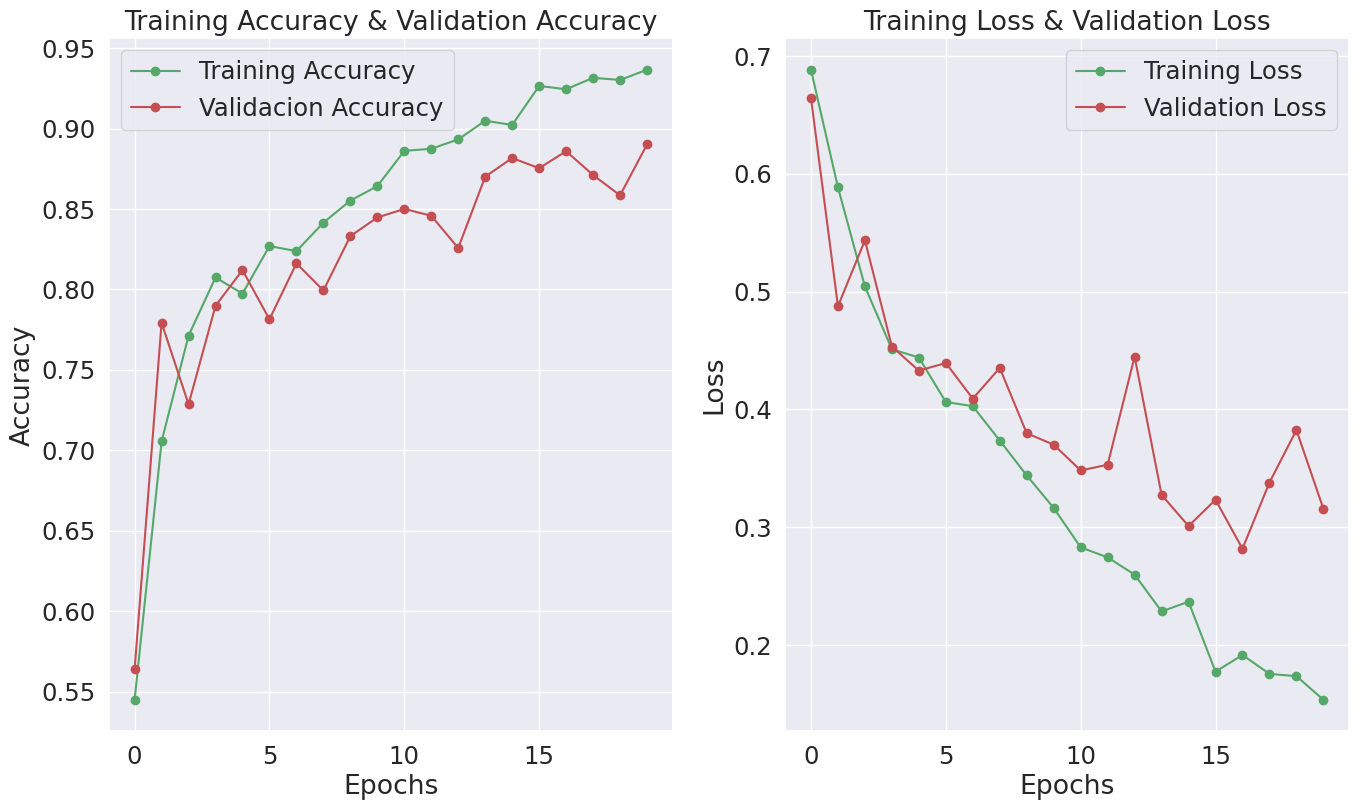

In [39]:
# Final Model

with tf.device(device_name):
  layer_sizes=[32,64,128, 128]
  pool=2
  kern=4

  random_seeds_reset()

  final_model = Sequential()

  final_model.add(Conv2D(layer_sizes[0], (kern,kern), input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu', padding='same'))
  final_model.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))

  final_model.add(Conv2D(layer_sizes[1], (kern,kern), activation='relu', padding='same'))
  final_model.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))

  final_model.add(Conv2D(layer_sizes[2], (kern,kern), activation='relu', padding='same'))
  final_model.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))

  final_model.add(Conv2D(layer_sizes[3], (kern,kern), activation='relu', padding='same'))
  final_model.add(MaxPooling2D(pool_size=(pool,pool), padding='same'))


  final_model.add(Flatten())
  final_model.add(Dropout(0.85))

  final_model.add(Dense(128, activation='relu'))


  final_model.add(Dense(1,activation='sigmoid'))

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

  final_model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])
  final_history=final_model.fit(X_train_c, Y, batch_size=32, epochs=20, validation_split=0.2, callbacks=[early_stopping])

  final_model.evaluate(X_test_c, y_test, return_dict=True)
  plot_function(final_history, 20)

In [40]:
# Confusion Matrix

loss, accuracy = final_model.evaluate(X_test_c, y_test, batch_size=32)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

val_predicts = final_model.predict(X_test)
predictions = [1 if x[0] >= 0.5 else 0 for x in val_predicts]
conf_matr = confusion_matrix(y_test, predictions)

print("Confusion Matrix:")
print(conf_matr)

misclassification_chihuahuas = conf_matr[0][1] / sum(conf_matr[0]) * 100
misclassification_muffins = conf_matr[1][0] / sum(conf_matr[1]) * 100
total_misclassification = (conf_matr[1][0] + conf_matr[0][1]) / sum(sum(conf_matr)) * 100

print("Chihuahuas misclassification:", round(misclassification_chihuahuas, 3), "%")
print("Muffins misclassification:", round(misclassification_muffins, 3), "%")
print("Total misclassification:", round(total_misclassification, 3), "%")

37/37 [==============================] - 0s 8ms/step - loss: 0.2413 - accuracy: 0.9105
Test Loss: 0.24126096069812775
Test Accuracy: 0.9104729890823364
37/37 [==============================] - 0s 7ms/step
Confusion Matrix:
[[604  36]
 [ 70 474]]
Chihuahuas misclassification: 5.625 %
Muffins misclassification: 12.868 %
Total misclassification: 8.953 %


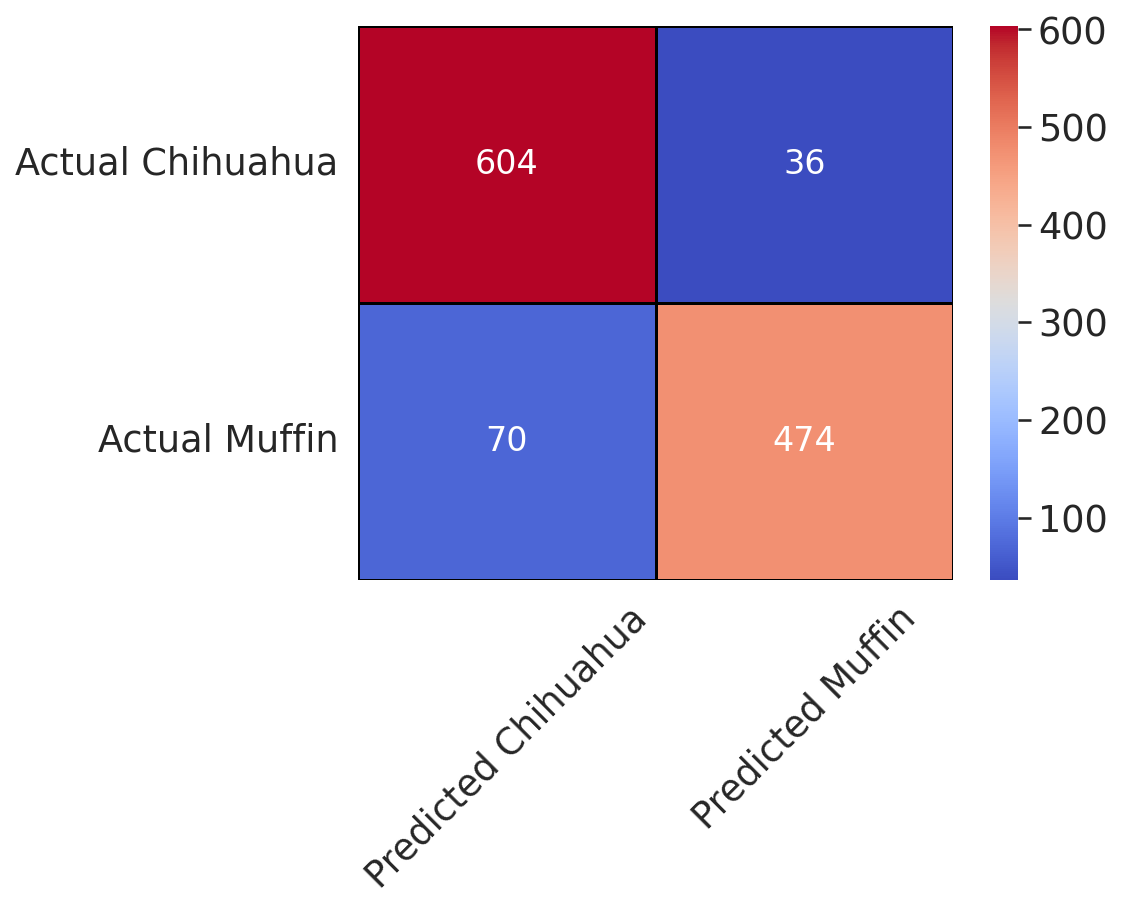

In [41]:
import seaborn as sns

labels = ["Actual Chihuahua", "Actual Muffin"]
columns = ["Predicted Chihuahua", "Predicted Muffin"]
df_cm = pd.DataFrame(conf_matr, labels, columns)

plt.figure(dpi=150)
sns.set(font_scale=1.6)
sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, cmap="coolwarm", linewidth=.7, linecolor='black', fmt='d')

plt.xticks(ticks=np.arange(2) + 0.5, labels=list(df_cm.columns), rotation=45, ha='center')

plt.show()

In [42]:
#5 fold cross-validation

device_name = '/gpu:0'

with tf.device(device_name):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    zero_one_losses = []
    accuracies = []

    for fold_index, (train_index, val_index) in enumerate(kf.split(X_train_c), start=1):
        print("\n Fold:", fold_index)

        X_train_fold, X_val_fold = X_train_c[train_index], X_train_c[val_index]
        y_train_fold, y_val_fold = Y[train_index], Y[val_index]


        random_seeds_reset()
        modelcv = Sequential()
        modelcv.add(Conv2D(32, (4, 4), activation="relu", input_shape=(150, 150, 1), padding='same'))
        modelcv.add(MaxPooling2D(2, 2))

        modelcv.add(Conv2D(32, (4, 4), activation="relu", padding='same'))
        modelcv.add(MaxPooling2D(2, 2))

        modelcv.add(Conv2D(64, (4, 4), activation="relu", padding='same'))
        modelcv.add(MaxPooling2D(2, 2))

        modelcv.add(Conv2D(128, (4, 4), activation="relu", padding='same'))
        modelcv.add(MaxPooling2D(2, 2))

        modelcv.add(Flatten())
        modelcv.add(Dropout(0.85))

        modelcv.add(Dense(128, activation="relu"))
        modelcv.add(Dense(1, activation="sigmoid"))

        modelcv.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=["accuracy"])
        monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=15, verbose=1, restore_best_weights=True)

        hist = modelcv.fit(
            x=X_train_fold,
            y=y_train_fold,
            epochs=60,
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            shuffle=True,
            callbacks=[monitor]
       )


        loss, accuracy = modelcv.evaluate(X_val_fold, y_val_fold)
        zero_one_loss = 1 - accuracy

        zero_one_losses.append(zero_one_loss)
        accuracies.append(accuracy)

print('0-1 Losses:', zero_one_losses)
mean_loss = np.mean(zero_one_losses)
print("Mean Zero-One Loss: {:.4f}".format(mean_loss))

print('Accuracies:', accuracies)
mean_acc = np.mean(accuracies)
print("Mean Accuracy: {:.4f}".format(mean_acc))


 Fold: 1
Epoch 1/60
119/119 [==============================] - 5s 22ms/step - loss: 0.6826 - accuracy: 0.5502 - val_loss: 0.6808 - val_accuracy: 0.6315
Epoch 2/60
119/119 [==============================] - 2s 16ms/step - loss: 0.5675 - accuracy: 0.7145 - val_loss: 0.5363 - val_accuracy: 0.7254
Epoch 3/60
119/119 [==============================] - 2s 16ms/step - loss: 0.4986 - accuracy: 0.7670 - val_loss: 0.4949 - val_accuracy: 0.7635
Epoch 4/60
119/119 [==============================] - 2s 16ms/step - loss: 0.4364 - accuracy: 0.8019 - val_loss: 0.4305 - val_accuracy: 0.8025
Epoch 5/60
119/119 [==============================] - 2s 16ms/step - loss: 0.3996 - accuracy: 0.8230 - val_loss: 0.4353 - val_accuracy: 0.8057
Epoch 6/60
119/119 [==============================] - 2s 16ms/step - loss: 0.3896 - accuracy: 0.8270 - val_loss: 0.3974 - val_accuracy: 0.8152
Epoch 7/60
119/119 [==============================] - 2s 15ms/step - loss: 0.3669 - accuracy: 0.8407 - val_loss: 0.4083 - val_accura